<a href="https://colab.research.google.com/github/cwcheng0/LionTravel/blob/master/LionTry1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 旅遊訂單成行預測
# Source https://tbrain.trendmicro.com.tw/Competitions/Details/4
# Filename: Lion Travel Try1
# Load basic libraries
# Reference Kaggle競賽-鐵達尼號生存預測 https://bit.ly/2EJubnu
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_absolute_error as MAE
import gc
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
# Mount personal Google Drive; all data files are in personal Google Drive
# account: My main account @ Gmail
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Create a file to see if it works
with open('/content/gdrive/My Drive/LionData/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/gdrive/My\ Drive/LionData/foo.txt

Hello Google Drive!

In [0]:
# Use PDrive function
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
# List files in root directory
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: LionData, id: 1wZoi3A5fUjpmu3y_cCdqsBEbXktRh1_l
title: 湯桂禎旅行社_20181019, id: 14ntE30_-iR-qc0P4pk31vkaO8OOcjCRGrEh5CxYtj5M
title: FINAL Brisbane Tourism Investment Guide, id: 1JdYmuHT19TZyV-uaizPK6PGopPQWu8xC
title: 詹宏志：論補貼與蝦皮之役_20180607, id: 1PySk7v0bswrM4-Lo1U8RFT7GcdepmDjeS2eEpfOY9nI
title: 創業家兄弟法說會_20180801.pdf, id: 14JhXbgTj-5QE9K4ac_pPlIPJ2iwUo4FK
title: submit-sample.json, id: 1s6CjebwO3s9Y3K6vrZhEC3UsaptWdXJD
title: 德國合作的药店_201805, id: 1doG5yuzIv6TCW8ENcBsA6P77yGqTxpp09ft9DuYCCaE
title: et_20180427.tar, id: 1ydPjPjjZihKBPKM3rLblDHQCvzTo1z-l
title: 東森-新客成交預測與舊客商品偏好預測_20180426.pdf, id: 1VLLGTPHvllOoTTiq45f8DGNp4E_WenAD
title: ai, id: 1kRULtH-0zQDSu5aL0JGNZEankknAWgpV
title: personal, id: 1aWTpM3zv5nf1ehe0fElvIMgL0nnjib27
title: bnbdata, id: 1N4KtGq1bwK122mkUS5hGyAkdJmkIbjo7
title: Colab Notebooks, id: 1SRIet5D_ShcqHVEsM2uLcwSg78TVmRlx
title: HelloFax, id: 0B0PbabVyLQgSV3ZPT1o4ZVdtakU
title: Picture, id: 0B0PbabVyLQgSbnJOQktZX3ViNUU


In [24]:
# Check first 5 rows in the airline file
airline = pd.read_csv('/content/gdrive/My Drive/LionData/airline.csv')
airline.head()

,group_id,go_back,fly_time,src_airport,arrive_time,dst_airport
0,63695,去程,2017/3/22 23:30,TPE 桃園機場,2017/3/22 14:15,HNL 檀香山機場
1,63695,回程,2017/4/1 14:30,LAX 洛杉機機場,2017/4/2 21:00,TPE 桃園機場
2,53481,去程,2017/5/17 23:00,TPE 桃園機場,2017/5/17 14:45,HNL 檀香山機場
3,53481,回程,2017/5/27 16:00,LAX 洛杉機機場,2017/5/28 21:05,TPE 桃園機場
4,54305,去程,2017/6/21 23:30,TPE 桃園機場,2017/6/21 14:15,HNL 檀香山機場


In [25]:
# Check the data in describe
airline.describe()

,group_id
count,74659.000000
mean,34267.785130
std,19835.756501
min,2.000000
25%,17203.000000
50%,34253.000000
75%,51432.000000
max,68572.000000


In [7]:
# Check first 5 rows in the group file
group = pd.read_csv('/content/gdrive/My Drive/LionData/group.csv')
group.head()

,group_id,sub_line,area,days,begin_date,price,product_name,promotion_prog
0,63695,subline_value_1,area_value_1,12,22-Mar-17,106900,最高省8000》大美西～夏威夷、優勝美地、西峽天空步道、聖地牙哥、環球影城(哈利波特)12日,&lt;B&gt;[GG]《行銷活動》[//]&lt;/B&gt;&lt;font face...
1,53481,subline_value_1,area_value_1,12,17-May-17,112900,《玩樂369》旗艦大美西12日～升等五星、優勝美地、西峽天空步道、卡利哥鬼鎮、環球影城大美西12日,&lt;B&gt;[GG]《行銷活動》[//]&lt;/B&gt;&lt;font face...
2,54305,subline_value_1,area_value_1,12,21-Jun-17,115900,《玩樂369》旗艦大美西12日～升等五星、優勝美地、西峽天空步道、卡利哥鬼鎮、環球影城大美西12日,&lt;B&gt;[GG]《行銷活動》[//]&lt;/B&gt;&lt;font face...
3,41766,subline_value_1,area_value_1,12,12-Jul-17,126900,《玩樂369》旗艦大美西12日～升等五星、優勝美地、西峽天空步道、卡利哥鬼鎮、環球影城大美西12日,&lt;B&gt;[GG]《行銷活動》[//]&lt;/B&gt;&lt;font face...
4,32196,subline_value_1,area_value_1,12,9-Aug-17,126900,《玩樂369》旗艦大美西12日～升等五星、優勝美地、西峽天空步道、卡利哥鬼鎮、環球影城大美西12日,&lt;B&gt;[GG]《行銷活動》[//]&lt;/B&gt;&lt;font face...


In [26]:
# Check the data in describe
group.describe()

,group_id,days,price
count,35292.000000,35292.000000,35292.000000
mean,34264.717075,6.189561,34508.904143
std,19833.398105,2.009243,20081.610913
min,2.000000,2.000000,3000.000000
25%,17199.750000,5.000000,20900.000000
50%,34264.500000,5.000000,29900.000000
75%,51403.750000,8.000000,38900.000000
max,68572.000000,17.000000,222900.000000


In [27]:
# Check first 5 rows in te day schedule file
schedule = pd.read_csv('/content/gdrive/My Drive/LionData/day_schedule.csv')
schedule.head()

,group_id,day,title
0,63695,1.0,台北 [AIR]歐胡島市區觀光【州政府．皇宮．國王銅像．中國城】
1,63695,2.0,夏威夷小環島【鑽石頭山．恐龍灣．噴泉口】－珍珠港[BOATS]豪華愛之船Star of Ho...
2,63695,3.0,夏威夷 [AIR] 舊金山
3,63695,4.0,舊金山市區觀光【藝術宮．金門大橋．金門公園．漁人碼頭．金門灣遊船．市政廳．雙子峰．九曲花街】
4,63695,5.0,舊金山－300KM－優勝美地國家公園－100KM－佛雷斯諾


In [28]:
# Check the data in describe
schedule.describe()

,group_id,day
count,218251.000000,218251.000000
mean,34246.612112,4.220191
std,19842.068634,2.647288
min,2.000000,1.000000
25%,17196.000000,2.000000
50%,34293.000000,4.000000
75%,51402.000000,6.000000
max,68572.000000,17.000000


In [9]:
# Check first 5 rows in the order file
order = pd.read_csv('/content/gdrive/My Drive/LionData/order.csv')
order.head()

,order_id,group_id,order_date,source_1,source_2,unit,people_amount
0,136100,63695,5-Jan-17,src1_value_1,src2_value_1,unit_value_1,2
1,140370,63695,9-Nov-16,src1_value_1,src2_value_1,unit_value_2,1
2,211009,63695,20-Jan-17,src1_value_1,src2_value_1,unit_value_3,2
3,41571,53481,14-Mar-17,src1_value_1,src2_value_1,unit_value_4,4
4,64125,53481,27-Mar-17,src1_value_2,src2_value_1,unit_value_5,1


In [10]:
# Check first 5 rows in the map file
cache = pd.read_csv('/content/gdrive/My Drive/LionData/cache_map.csv')
cache.head()

,file_name,url
0,lion_cache_1.jpg,https://www.liontravel.com/Comm/2TRS/HotSale/p...
1,lion_cache_2.jpg,https://www.liontravel.com/Comm/2TRS/HotSale/p...
2,lion_cache_3.jpg,https://www.liontravel.com/Comm/2trs/hotsale/p...
3,lion_cache_4.jpg,https://www.liontravel.com/Comm/2TRS/HotSale/p...
4,lion_cache_5.jpg,https://www.liontravel.com/Comm/2TRS/HotSale/p...


In [29]:
# Check the data in describe
cache.describe()

,file_name,url
count,321,321
unique,321,321
top,lion_cache_241.gif,https://www.liontravel.com/Comm/2TRS/HotSale/p...
freq,1,1


In [11]:
# Check first 5 rows in the test data
# Second column is the target we want to predict
test = pd.read_csv('/content/gdrive/My Drive/LionData/testing-set.csv')
test.head()

,order_id,deal_or_not
0,136100,NaN
1,140370,NaN
2,211009,NaN
3,5045,NaN
4,37230,NaN


In [12]:
# 使用info()函式觀察 test 資料是否有空值
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150400 entries, 0 to 150399
Data columns (total 2 columns):
order_id       150400 non-null int64
deal_or_not    0 non-null float64
dtypes: float64(1), int64(1)
memory usage: 2.3 MB


In [33]:
# 使用info()函式觀察 training 資料是否有空值
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146620 entries, 0 to 146619
Data columns (total 2 columns):
order_id       146620 non-null int64
deal_or_not    146620 non-null int64
dtypes: int64(2)
memory usage: 2.2 MB


In [34]:
# 使用 Describe 來觀察 train 資料分布
train.describe()

,order_id,deal_or_not
count,146620.000000,146620.000000
mean,156364.018067,0.199182
std,95558.835525,0.399386
min,1.000000,0.000000
25%,74837.750000,0.000000
50%,150172.000000,0.000000
75%,233551.000000,0.000000
max,340111.000000,1.000000


In [32]:
# Check first 5 rows in the training data
# This is the training file
train = pd.read_csv('/content/gdrive/My Drive/LionData/training-set.csv')
train.head()

,order_id,deal_or_not
0,41571,1
1,64125,1
2,76131,0
3,238671,0
4,93305,1


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


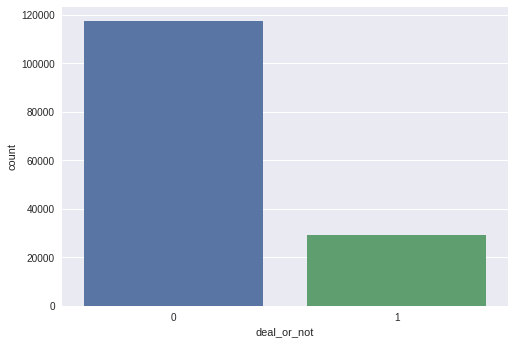

In [20]:
# Visual the data; from describe(), it shows about 19.9% to have a group.
import seaborn as sns
sns.countplot(train['deal_or_not'])

In [0]:
# Data merge: merge data in the provided files
# 查詢以下資料特徵:是否容易成團
# 價錢高低/資料來源1或2/出團時間是否假日/出發機場/目的地area/天數/標題/圖片/目的地機場/團費
# Airbnb Expreience: 切割目的地:亞洲/歐洲/美洲,以提高準確率


In [16]:
group.iloc[0]

group_id                                                      63695
sub_line                                            subline_value_1
area                                                   area_value_1
days                                                             12
begin_date                                                22-Mar-17
price                                                        106900
product_name         最高省8000》大美西～夏威夷、優勝美地、西峽天空步道、聖地牙哥、環球影城(哈利波特)12日
promotion_prog    &lt;B&gt;[GG]《行銷活動》[//]&lt;/B&gt;&lt;font face...
Name: 0, dtype: object

In [47]:
# Merge all data

result1 = pd.merge(ariline, group, on='group_id')

result2 = pd.merge(result1, schedule, on='group_id')

result3 = pd.merge(result2, order, on='group_id')

# Combine training data and all usefule data
result4 = pd.merge(result3, train, on='order_id')

# Show first 5 results
result4.head()

,group_id,go_back,fly_time,src_airport,arrive_time,dst_airport,sub_line,area,days,begin_date,...,promotion_prog,day,title,order_id,order_date,source_1,source_2,unit,people_amount,deal_or_not
0,53481,去程,2017/5/17 23:00,TPE 桃園機場,2017/5/17 14:45,HNL 檀香山機場,subline_value_1,area_value_1,12,17-May-17,...,&lt;B&gt;[GG]《行銷活動》[//]&lt;/B&gt;&lt;font face...,1.0,台北 [AIR]歐胡島市區觀光【州政府．皇宮．國王銅像．中國城】,41571,14-Mar-17,src1_value_1,src2_value_1,unit_value_4,4,1
1,53481,去程,2017/5/17 23:00,TPE 桃園機場,2017/5/17 14:45,HNL 檀香山機場,subline_value_1,area_value_1,12,17-May-17,...,&lt;B&gt;[GG]《行銷活動》[//]&lt;/B&gt;&lt;font face...,2.0,夏威夷小環島【鑽石頭山．恐龍灣．噴泉口】－珍珠港[BOATS]豪華愛之船Star of Ho...,41571,14-Mar-17,src1_value_1,src2_value_1,unit_value_4,4,1
2,53481,去程,2017/5/17 23:00,TPE 桃園機場,2017/5/17 14:45,HNL 檀香山機場,subline_value_1,area_value_1,12,17-May-17,...,&lt;B&gt;[GG]《行銷活動》[//]&lt;/B&gt;&lt;font face...,3.0,夏威夷 [AIR] 舊金山,41571,14-Mar-17,src1_value_1,src2_value_1,unit_value_4,4,1
3,53481,去程,2017/5/17 23:00,TPE 桃園機場,2017/5/17 14:45,HNL 檀香山機場,subline_value_1,area_value_1,12,17-May-17,...,&lt;B&gt;[GG]《行銷活動》[//]&lt;/B&gt;&lt;font face...,4.0,舊金山市區觀光【藝術宮．金門大橋．金門公園．漁人碼頭．金門灣遊船．市政廳．雙子峰．九曲花街】,41571,14-Mar-17,src1_value_1,src2_value_1,unit_value_4,4,1
4,53481,去程,2017/5/17 23:00,TPE 桃園機場,2017/5/17 14:45,HNL 檀香山機場,subline_value_1,area_value_1,12,17-May-17,...,&lt;B&gt;[GG]《行銷活動》[//]&lt;/B&gt;&lt;font face...,5.0,舊金山－300KM－優勝美地國家公園－100KM－佛雷斯諾,41571,14-Mar-17,src1_value_1,src2_value_1,unit_value_4,4,1


In [48]:
# check data type
result4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2133031 entries, 0 to 2133030
Data columns (total 22 columns):
group_id          int64
go_back           object
fly_time          object
src_airport       object
arrive_time       object
dst_airport       object
sub_line          object
area              object
days              int64
begin_date        object
price             int64
product_name      object
promotion_prog    object
day               float64
title             object
order_id          int64
order_date        object
source_1          object
source_2          object
unit              object
people_amount     int64
deal_or_not       int64
dtypes: float64(1), int64(6), object(15)
memory usage: 374.3+ MB


In [49]:
# Check data
result4.describe()

,group_id,days,price,day,order_id,people_amount,deal_or_not
count,2.133031e+06,2.133031e+06,2.133031e+06,2.133031e+06,2.133031e+06,2.133031e+06,2.133031e+06
mean,3.430939e+04,7.561916e+00,4.552123e+04,4.606551e+00,1.563276e+05,3.018747e+00,1.958757e-01
std,1.979476e+04,2.463420e+00,2.476587e+04,2.894103e+00,9.559520e+04,2.940316e+00,3.968734e-01
min,2.000000e+00,3.000000e+00,7.500000e+03,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.753400e+04,5.000000e+00,2.790000e+04,2.000000e+00,7.475500e+04,2.000000e+00,0.000000e+00
50%,3.411000e+04,8.000000e+00,3.890000e+04,4.000000e+00,1.502820e+05,2.000000e+00,0.000000e+00
75%,5.147300e+04,1.000000e+01,6.090000e+04,6.000000e+00,2.334620e+05,4.000000e+00,0.000000e+00
max,6.856900e+04,1.600000e+01,2.229000e+05,1.700000e+01,3.401110e+05,5.000000e+01,1.000000e+00


In [51]:
# how to fill items into empty items
# in different columns, it should have different ways.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2133031 entries, 0 to 2133030
Data columns (total 22 columns):
group_id          int64
go_back           object
fly_time          object
src_airport       object
arrive_time       object
dst_airport       object
sub_line          object
area              object
days              int64
begin_date        object
price             int64
product_name      object
promotion_prog    object
day               float64
title             object
order_id          int64
order_date        object
source_1          object
source_2          object
unit              object
people_amount     int64
deal_or_not       int64
dtypes: float64(1), int64(6), object(15)
memory usage: 374.3+ MB
